# Softmax Classification (with Cross-Entropy Loss)

In this exercise you will:

- Implement a fully-vectorized **loss function** for the Softmax classifier
- Implement the fully-vectorized expression for its **analytic gradient**
- **Check your implementation** with numerical gradient
- Use a validation set to **tune the learning rate and regularization** strength
- **Optimize** the loss function with **SGD**
- **Visualize** the final learned weights


In [1]:
import time
import random
import math
import numpy as np
from exercise_code.model_savers import save_softmax_classifier
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

To your convenience, we have taken care of all the input handling. Nevertheless, you should go through the following code line by line so that you understand the general preprocessing pipeline.
The whole dataset is loaded, then subdivided into a training, validation and test dataset (the last one is different from the final evaluation dataset on our server!).

Before proceeding you should *always* take a look at some samples of your dataset, which is already implemented for you. This way you can make sure that the data input/preprocessing has worked as intended and you can get a feeling for the dataset.

In [2]:
from exercise_code.data_utils import load_CIFAR10
# Load the raw CIFAR-10 data
cifar10_dir = 'datasets/'
X, y = load_CIFAR10(cifar10_dir)

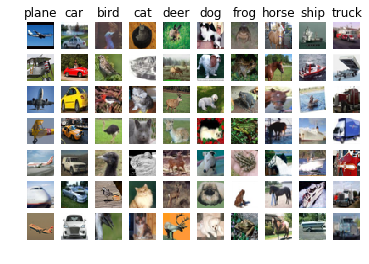

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(y == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the data set;
# we can use this for development so our code runs faster.
num_training = 48000
num_validation = 1000
num_test = 1000
num_dev = 500

assert (num_training + num_validation + num_test) == 50000, 'You have not provided a valid data split.'

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X[mask]
y_train = y[mask]

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X[mask]
y_val = y[mask]

# We use a small subset of the training set as our test set.
mask = range(num_training + num_validation, num_training + num_validation + num_test)
X_test = X[mask]
y_test = y[mask]

# We will also make a development set, which is a small subset of
# the training set. This way the development cycle is faster.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (48000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64297917 135.92841667 132.4100625  130.0744375  135.3130625
 131.70479167 131.0373125  136.18741667 132.48804167 131.65420833]


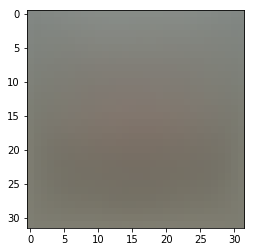

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(48000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Softmax Classifier

In this section you will implement the essential elements of a softmax classifier. We will start with the cross-entropy loss and it's gradient with respect to the classifier's weights. We suggest that you first derive these expressions on paper.

### Naive Implementation
First implement a naive cross-entropy loss function with nested loops. Open the file `exercise_code/classifiers/softmax.py` and implement the loss of the softmax classifier into the `cross_entropy_loss_naive` function.

Running this method might take a while...

In [10]:
from exercise_code.classifiers.softmax import cross_entropy_loss_naive

# Generate a random weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = cross_entropy_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.324659
sanity check: 2.302585


<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Why do we expect our loss to be close to -log(0.1)? Explain briefly.</p>
</div>

Complete the implementation of the `cross_entropy_loss_naive` function and implement a (naive) version of the gradient that uses nested loops. Use the following cell to check your results:

In [11]:
from exercise_code.gradient_check import grad_check_sparse
# We take a smaller dev set since the naive implementation takes quite some while
X_dev_small, y_dev_small = X_dev[:10], y_dev[:10]

loss, grad = cross_entropy_loss_naive(W, X_dev_small, y_dev_small, 0.0)

# We use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: cross_entropy_loss_naive(w, X_dev_small, y_dev_small, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Again, running this might take a while!

numerical: 2.755140768240238 analytic: 2.7551404360482064, relative error: 6.028585826102583e-08
numerical: -4.030982661373805 analytic: -4.030982742374798, relative error: 1.004730094008498e-08
numerical: 1.918904108255681 analytic: 1.9189039855945549, relative error: 3.196124536338135e-08


In [12]:
# Do another gradient check with regularization
loss, grad = cross_entropy_loss_naive(W, X_dev_small, y_dev_small, 1e2)
f = lambda w: cross_entropy_loss_naive(w, X_dev_small, y_dev_small, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

numerical: -8.650876229299165 analytic: -8.650876199824692, relative error: 1.703554178172785e-09
numerical: 2.063724829359792 analytic: 2.063724621798515, relative error: 5.028802399904153e-08
numerical: 0.8156356372746031 analytic: 0.8156353725339622, relative error: 1.6229102292763124e-07


### Vectorized Implementation
Now that we have a naive implementation of the cross-entropy loss and its gradient, implement a vectorized version in `cross_entropy_loss_vectorized`.

The two versions should compute the same results, but the vectorized version should be much faster.

In [15]:
from exercise_code.classifiers.softmax import cross_entropy_loss_vectorized

tic = time.time()
loss_vectorized, grad_vectorized = cross_entropy_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()

tic = time.time()
loss_naive, grad_naive = cross_entropy_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = cross_entropy_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)


naive loss: 2.324659e+00 computed in 163.668594s
vectorized loss: 2.324659e+00 computed in 0.005984s
Loss difference: 0.000000
Gradient difference: 0.000000


<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>When you compute the softmax distribution, you are dividing by a sum of exponentials, i.e. potentially very large numbers, which can be numerically unstable. Do you see a way to avoid this problem?
</p>
    <p>(Hint: exploit properties of the exponential function to arrive at an expression that is mathematically the same, but numerically more stable)</p>
</p>
</div>

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to usw SGD to minimize the loss. In the file `exercise_code/classifiers/linear_classifier.py`, implement SGD in the `LinearClassifier.train` method and test it with the code below.

In [16]:
from exercise_code.classifiers.softmax import SoftmaxClassifier

# The SoftmaxClassifier class inherits from LinearClassifier
softmax = SoftmaxClassifier()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                          num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 1537.146300
iteration 100 / 1500: loss 207.018428
iteration 200 / 1500: loss 29.509679
iteration 300 / 1500: loss 5.820361
iteration 400 / 1500: loss 2.584796
iteration 500 / 1500: loss 2.184685
iteration 600 / 1500: loss 2.063874
iteration 700 / 1500: loss 2.225698
iteration 800 / 1500: loss 2.118039
iteration 900 / 1500: loss 2.137925
iteration 1000 / 1500: loss 2.106650
iteration 1100 / 1500: loss 2.149715
iteration 1200 / 1500: loss 2.148487
iteration 1300 / 1500: loss 2.132631
iteration 1400 / 1500: loss 2.132452
That took 10.981651s


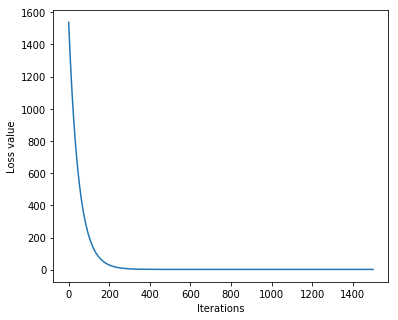

In [17]:
# A useful debugging strategy is to plot the loss as a function of iterations:
plt.figure(figsize=(6,5))
plt.plot(loss_hist)
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.show()

Write the `LinearClassifier.predict` method and evaluate the performance on both the training and validation set:

In [18]:
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.307979
validation accuracy: 0.303000


### Training your Softmax Classifier
Use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of over 0.35 on the validation set. Implement the `softmax_hyperparameter_tuning` function in `exercise_code/classifiers/softmax.py`.

In [20]:
from exercise_code.classifiers.softmax import SoftmaxClassifier, softmax_hyperparameter_tuning

best_softmax, results, all_classifiers = softmax_hyperparameter_tuning(X_train, y_train, X_val, y_val)

lr 4.000000e-07 reg 3.000000e+03
train accuracy: 0.384500 val accuracy: 0.369000
lr 4.000000e-07 reg 6.000000e+03
train accuracy: 0.368188 val accuracy: 0.349000
lr 4.000000e-07 reg 1.200000e+04
train accuracy: 0.351438 val accuracy: 0.334000
lr 4.000000e-07 reg 2.400000e+04
train accuracy: 0.332583 val accuracy: 0.327000
lr 4.000000e-07 reg 4.800000e+04
train accuracy: 0.306604 val accuracy: 0.305000
lr 5.656854e-07 reg 3.000000e+03
train accuracy: 0.382542 val accuracy: 0.367000
lr 5.656854e-07 reg 6.000000e+03
train accuracy: 0.367521 val accuracy: 0.362000
lr 5.656854e-07 reg 1.200000e+04
train accuracy: 0.345604 val accuracy: 0.344000
lr 5.656854e-07 reg 2.400000e+04
train accuracy: 0.315437 val accuracy: 0.308000
lr 5.656854e-07 reg 4.800000e+04
train accuracy: 0.300708 val accuracy: 0.298000
lr 8.000000e-07 reg 3.000000e+03
train accuracy: 0.373021 val accuracy: 0.359000
lr 8.000000e-07 reg 6.000000e+03
train accuracy: 0.361333 val accuracy: 0.364000
lr 8.000000e-07 reg 1.200000

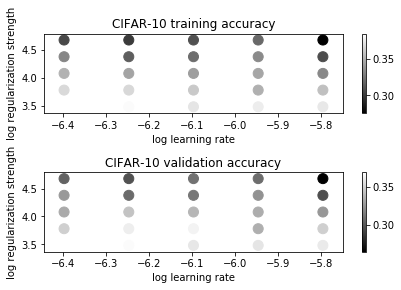

In [21]:
# Visualize the validation results
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

plt.tight_layout()
plt.show()

In [22]:
# if you want to take a look at the other classifiers assign them to best_softmax here
sorted_classifiers = sorted(all_classifiers, key=lambda x : x[1])
best_softmax = sorted_classifiers[-1][0]

In [23]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.386000


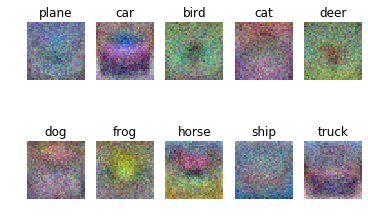

In [24]:
# Visualize the learned weights for each class
#best_softmax = sorted_classifiers[idx][0]
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe what your visualized Softmax weights look like.</p>
</div>

## Save the model

When you are satisfied with your training, save the model for submission. Your final score is computed by `accuracy * 100`. In order to pass this exercise, you have to achieve a score higher than __35__.

<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>You might get an error like this:</p>
    <p>PicklingError: Can't pickle `<class 'exercise_code.classifiers.softmax.SoftmaxClassifier'>`: it's not the same object as exercise_code.classifiers.softmax.SoftmaxClassifier</p>
    <p>The reason is that we are using autoreload and working on this class during the notebook session. If you get this error simply restart the kernel and rerun the whole script (Kernel -> Restart & Run All) or only the important cells for generating your model.</p>
</div>

In [25]:
from exercise_code.model_savers import save_softmax_classifier
from exercise_code.classifiers.softmax import SoftmaxClassifier

save_softmax_classifier(best_softmax)

## Submission 1

The softmax classifier is submission 1. To earn the bonus you need to achieve a score higher than __35__.